# Tutorial 1: Gaze in Ego-Exo4D Dataset

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Tutorial&message=View%20On%20Github&color=lightgrey)](https://github.com/facebookresearch/Ego4d/tree/main/notebooks/egoexo)   
**Author:** Xizi Wang

In this tutorial, we provide an introduction of the gaze data in Ego-Exo4D dataset, and a step-by-step guide on how to project 3D eye gaze to 2D in Egocentric/Exocentric view. 

Eye gaze is one of the 3D spatial signals provided by Ego-Exo4D dataset, which is pre-computed by Project Aria’s machine perception service (MPS). The gaze direction of the user is estimated as a single outward-facing ray anchored in-between the wearer’s eyes. Left and right eye gaze directions (yaw values) along with the depth at which these gaze directions intersect (translation values) are provided in the dataset. The convergence points and distances are derived from the predicted gaze directions. The combined direction’s yaw is used to populate the yaw field of the EyeGaze object for backwards compatibility. The pitch is common to left, right and combined gaze directions.

<center><img src="https://facebookresearch.github.io/projectaria_tools/img/data_formats/eye_gaze_032024_model.png" width=400 height=400 /></center>

Eye gaze data is located in each captures' or takes' eye_gaze folder. You can determine if a take or capture has eye gaze data by using `has_gaze` for a capture in <b>captures.json</b> and `has_trimmed_eye_gaze` for a take in <b>takes.json</b>. If eye gaze is available for the take, it is trimmed (cropped in time) with respect to that take. You will find the following Eye Gaze MPS file outputs under the take folder. *Note that personalized eye gaze might not be available for all takes.*
- `summary.json` - high level report on MPS eye gaze generation
- `general_eye_gaze.csv` - based on the standard eye gaze configuration
- `personalized_eye_gaze.csv` - eye gaze data based on the calibration data collected in the recording, please check <a href="https://facebookresearch.github.io/projectaria_tools/docs/ARK/mps/eye_gaze_calibration">in-session Eye Gaze Calibration</a>
- `general_eye_gaze_2d.csv` - 2D eye gaze coordinates projected on egocentric view
- `personalized_eye_gaze_2d.csv` - 2D eye gaze coordinates projected on egocentric view based on the calibration data

### 1. Prerequisites and Imports

Before we get started, we need to install necessary libraries. We will install the Python Package for Project Aria Tools. Please check <a href="https://facebookresearch.github.io/projectaria_tools/docs/data_utilities/installation/installation_python">Installation guide</a> for detailed instructions. 

In [1]:
# install projectaria_tools
!git clone https://github.com/facebookresearch/projectaria_tools.git -b 1.5.5
!python3 -m pip install --upgrade pip
!python3 -m pip install projectaria-tools'[all]' --quiet

# install opencv-python
!pip install opencv-python --quiet

fatal: destination path 'projectaria_tools' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, http://webservice


Then we import some necessary libraries.

In [2]:
import numpy as np
from tqdm import tqdm
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from moviepy import VideoFileClip
import cv2
import math

# project Aria tools
from projectaria_tools.core.calibration import CameraCalibration, DeviceCalibration, KANNALA_BRANDT_K3
from projectaria_tools.core.sophus import SE3
from projectaria_tools.core import mps, data_provider
from projectaria_tools.core.mps.utils import get_gaze_vector_reprojection
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.utils.rerun_helpers import AriaGlassesOutline, ToTransform3D

### 2. Load one sample take and its VRS and MPS data

We will load one take **fair_cooking_05_2** on cooking as an example. You need to change `ego_exo_root` to the download directory for the Ego-Exo4D dataset. As mentioned earlier, some takes might have personalized eye gaze which is based on calibrated data. We use a boolean variable `use_general_gaze` to choose whether general eye gaze or personalized eye gaze is used. 

In [3]:
ego_exo_root = '/datasets01/egoexo4d/v2/' # Replace with your cli's download directory for Ego-Exo4D
take_name = 'fair_cooking_05_2'

ego_exo_project_path = os.path.join(ego_exo_root, 'takes', take_name)
assert os.path.exists(ego_exo_project_path), "Please do update your path to a valid EgoExo sequence folder."

use_general_gaze = True
if not use_general_gaze:
    assert os.path.exists(os.path.join(ego_exo_project_path, "eye_gaze", "personalized_eye_gaze.csv")), "personalized eye gaze not exists for this take"


# find aria number, for example, aria03.vrs will have aria_number = 3
pattern = re.compile(r'aria0(\d+)\.vrs')

for root, _, files in os.walk(ego_exo_project_path):
    for file in files:
        match = pattern.match(file)
        if match:
            aria_number = int(match.group(1))

We retrieve the VRS data including device calibration collected by Aria glasses and plot sensors locations, orientations. 
 - VRS: <a href="https://facebookresearch.github.io/vrs/">VRS</a> is the file format used to store the Project Aria Glasses multimodal data. VRS Data is stored Stream and are identified with a unique StreamId. `VrsDataProvider` enables you to list and retrieve all VRS data and calibration data.
 - DeviceCalibration: an interface that can be used to retrieve Intrinsics for Image Stream data (i.e Camera data) - `CameraCalibration` and Extrinsics defined for all sensors - `SE3`.

Project Aria glasses use 3D Coordinate Frame Conventions. You can find an overview of these conventions <a href="3D Coordinate Frame Conventions">here</a> where Central Pupil Frame (CPF) and 3D Coordinate frame and system conventions are covered. We use the projectaria_tools API for retrieving the DeviceCalibration and the POSE of each sensor. 

First of all, we load the VRS file of the sample take.

In [4]:
vrs_file_path = os.path.join(ego_exo_project_path, f'aria0{aria_number}.vrs')
print(f"VRS file path: {vrs_file_path}")
assert os.path.exists(vrs_file_path), "We are not finding the required vrs file"

vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)
assert vrs_data_provider, "Couldn't create data vrs_data_provider from vrs file"

VRS file path: /datasets01/egoexo4d/v2/takes/fair_cooking_05_2/aria02.vrs


[ProgressLogger][INFO]: 2024-12-06 21:52:21: Opening /datasets01/egoexo4d/v2/takes/fair_cooking_05_2/aria02.vrs...
[MultiRecordFileReader][DEBUG]: Opened file '/datasets01/egoexo4d/v2/takes/fair_cooking_05_2/aria02.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 281-1/gps activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO]: streamId 1202-2/imu-left activated
[VrsDataProvider][INFO]: streamId 1203-1/mag0 activated


Next, we load the device calibration of the aria glasses, and the pose of the <a href="https://facebookresearch.github.io/projectaria_tools/docs/data_formats/coordinate_convention/3d_coordinate_frame_convention#the-nominal-central-pupil-frame-cpf">central-pupil-frame</a> in the device frame. 

In [5]:
device_calibration = vrs_data_provider.get_device_calibration()

# CPF (Central Pupil Frame coordinate system)
T_device_CPF = device_calibration.get_transform_device_cpf()

Now let's check out the project aria glasses outline and the CPF coordinate system in the figure below.

<center><img src="./figs/aria_glasses.png" width=600 height=600 /></center>

We can get RGB and SLAM left and right stream label from a given StreamId.

In [6]:
rgb_stream_id = StreamId("214-1")
slam_left_stream_id = StreamId("1201-1")
slam_right_stream_id = StreamId("1201-2")
rgb_stream_label = vrs_data_provider.get_label_from_stream_id(rgb_stream_id)
slam_left_stream_label = vrs_data_provider.get_label_from_stream_id(slam_left_stream_id)
slam_right_stream_label = vrs_data_provider.get_label_from_stream_id(slam_right_stream_id)

We can further retrieve time domain, and image configurations from the stream.

In [7]:
# Configure option for data retrieval
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time

# Retrieve Start and End time for the given Sensor Stream Id
start_time = vrs_data_provider.get_first_time_ns(rgb_stream_id, time_domain)
end_time = vrs_data_provider.get_last_time_ns(rgb_stream_id, time_domain)

# FYI, you can retrieve the Image configuration using the following
image_config = vrs_data_provider.get_image_configuration(rgb_stream_id)
width = image_config.image_width
height = image_config.image_height
print(f"StreamId {rgb_stream_id}, StreamLabel {rgb_stream_label}, ImageSize: {width, height}")

StreamId 214-1, StreamLabel camera-rgb, ImageSize: (1408, 1408)


Now let's retrieve the stream from RGB, SLAM left and right cameras. To retrieve the timestamps of the take, we need to follow the steps below. Please also check <a href="https://docs.ego-exo4d-data.org/data/takes/#take-timing-information">Take Time Information</a> for more details.

In [21]:
# Load the takes.json annotation
takes_info = json.load(open(os.path.join(ego_exo_root, "takes.json")))

# go through all takes to locate the sampled take, i.e., cmu_bike01_5
for take in takes_info:
    if take["take_name"] == take_name: break

# get the capture name, and load the timesync.csv
capture_name = re.sub(r"_\d+$", "", take_name)
timesync = pd.read_csv(os.path.join(ego_exo_root, f"captures/{capture_name}/timesync.csv"))

start_idx = take["timesync_start_idx"]+1
end_idx = take["timesync_end_idx"]
take_timestamps = []
for idx in range(start_idx, end_idx):
    take_timestamps.append(int(timesync.iloc[idx][f"aria0{aria_number}_214-1_capture_timestamp_ns"]))

We can retrieve the RGB image and SLAM images from VRS data, and visualize the frames from RGB, SLAM left and right cameras with the timestamps.

In [9]:
# we sample 1/100 frames for faster visualization
sample_freq=100
sample_frame_num=400
for sample in take_timestamps[:sample_frame_num:sample_freq]:

    # Retrieve the RGB image
    image_tuple_rgb = vrs_data_provider.get_image_data_by_time_ns(rgb_stream_id, int(sample), time_domain, option)
    timestamp = image_tuple_rgb[1].capture_timestamp_ns

    # Retrieving the SLAM images
    image_tuple_slam_left = vrs_data_provider.get_image_data_by_time_ns(slam_left_stream_id, int(sample), time_domain, option)

    image_tuple_slam_right = vrs_data_provider.get_image_data_by_time_ns(slam_right_stream_id, int(sample), time_domain, option)

<center><img src="./figs/rgb_slam.png" width=600 height=600 /></center>

### 3. Projecting eye gaze from 3D to 2D in Egocentric View (CPF frame)

Here we show how to project eye gaze data to egocentric view. Eye gaze data is represented as a 3D ray with depth (showing the point of user focus). The eye gaze ray starts from the Central Pupil Frame(CPF). The reprojection of eye gaze ray in any Aria Image Stream (RGB, SLAMs) includes the following 3 steps:
 1. We retrieve the frames from the egocentric video corresponding to the RGB stream of the aria glasses.
 2. Use the `MpsDataProvider` to retrieve if an EyeGaze file is available and to retrieve EyeGaze data at a given timestamp
 3. Compute the corresponding 3D eye gaze vector and retrieve its depth

In [10]:
# load the egocentric video with cv2, and load the first sample_frame_num=400 frames
ego_video = os.path.join(ego_exo_root, 'takes', take_name, "frame_aligned_videos", f"aria0{aria_number}_214-1.mp4")

# we sample the first 400 frames, with a sampling rate of 1 frame per 100 frames to acelerate the processing and visualization.
sample_frame_num = 400
sample_freq = 100
cap = cv2.VideoCapture(ego_video)
ego_frames = []

for i in range(sample_frame_num):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if not ret:
        break
    ego_frames.append(frame)

cap.release()

In [11]:
## Configure the MpsDataProvider (interface used to retrieve Trajectory data)
mps_data_paths_provider = mps.MpsDataPathsProvider(ego_exo_project_path)
mps_data_paths = mps_data_paths_provider.get_data_paths()
mps_data_provider = mps.MpsDataProvider(mps_data_paths)
assert mps_data_provider.has_general_eyegaze(), "The sequence does not have Eye Gaze data"

rgb_camera_calibration = device_calibration.get_camera_calib(rgb_stream_label)

[MpsDataPathsProvider][WARNING]: Hand tracking folder (/datasets01/egoexo4d/v2/takes/fair_cooking_05_2/hand_tracking) does not exist in MPS root folder, not loading wrist and palm poses.


Let's reproject the 3D eye gaze to the egocentric view at all timestamps, and concatenate the projected 2D eye gaze on egocentric view to a list `gazes`.

In [12]:
gazes = []
for sample in take_timestamps:

    # get the eye gaze data at each timestamp with mps_data_provider
    if use_general_gaze:
        eye_gaze = mps_data_provider.get_general_eyegaze(sample)
    else:
        eye_gaze = mps_data_provider.get_personalized_eyegaze(sample)

    # compute the corresponding 3D vector and retrieve its depth. Depth is set to default of 1.0 if eye gaze data doesn't provide depth.
    depth_m = eye_gaze.depth or 1.0

    # reproject the eye_gaze vector at Depth on a given image (using Calibration data)
    gaze_projection = get_gaze_vector_reprojection(
        eye_gaze,
        rgb_stream_label,
        device_calibration,
        rgb_camera_calibration,
        depth_m,
    )
    gazes.append(gaze_projection)

Loaded #EyeGazes: 5096


For some takes, we've released a file named `general_eye_gaze_2d.csv` which stores the projected eye gaze at a lower fps. As a result, another way of getting the 2D project eye gaze on the egocentric view is to read the gazes from this file.

In [13]:
gaze_2d = pd.read_csv(os.path.join(ego_exo_root, 'takes', take_name, "eye_gaze/general_eye_gaze_2d.csv"))
x_values = gaze_2d['x'].tolist()
x_values = [num for num in x_values for _ in range(3)]
y_values = gaze_2d['y'].tolist()
y_values = [num for num in y_values for _ in range(3)]
gaze_2d_csv = list(map(lambda x, y: (x, y), x_values, y_values))[1:]

With the projected eye gazes, we can visualize them on the egocentric videos. We sample some frames for faster visualization.

In [14]:
ego_frames_with_points = {}
for i in list(range(len(take_timestamps)))[:sample_frame_num:sample_freq]:
    # retrieve the projected eye gaze from the MPS_data_provider
    mps_pointx, mps_pointy = gazes[i]

    # retrieve the 2D eye gaze from general_eye_gaze_2d.csv
    point_x, point_y = gaze_2d_csv[i][0], gaze_2d_csv[i][1]

    # rotate the projected eye gaze 90 degree clockwise to align with the egocentric view
    mps_pointx_new = width - 1 - mps_pointy
    mps_pointy_new = mps_pointx
    mps_pointx, mps_pointy = mps_pointx_new, mps_pointy_new
    img = Image.fromarray(ego_frames[i])
    
    draw = ImageDraw.Draw(img)

    # Draw the eye gaze from MPS on the image (color: green)
    draw.ellipse((mps_pointx-25, mps_pointy-25, mps_pointx+25, mps_pointy+25), fill=(0, 255, 0))
    # Draw the eye gaze from the CSV file on the image (color: red)
    draw.ellipse((point_x-25, point_y-25, point_x+25, point_y+25), fill=(255, 0, 0))
    
    # Append the frame with point to the list
    ego_frames_with_points[take_timestamps[i]] = np.array(img)

The green dots show the eye gaze from MPS projected on the image. The red dots show the eye gaze read from the general_eye_gaze_2d.csv on the image.

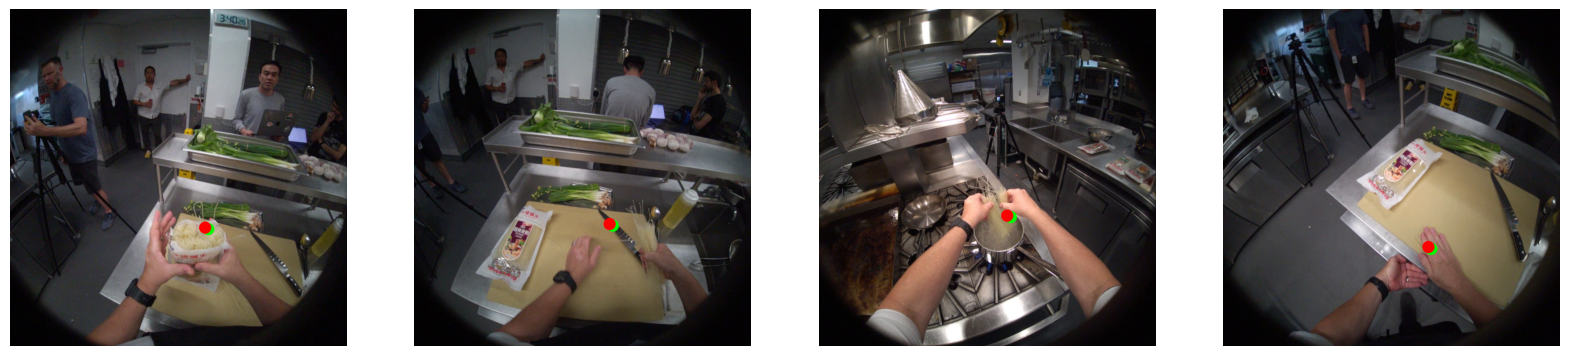

In [15]:
f, axarr = plt.subplots(1,4, figsize=(20, 10))
for i, ax in enumerate(axarr.flat):
    key = list(ego_frames_with_points.keys())[i]
    ax.imshow(ego_frames_with_points[key], cmap='gray')
    ax.axis('off')

### 4. Projecting eye gaze from 3D to 2D in multiple Exocentric Views

In this section, let's project the eye gaze to the exocentric views. First we need to get the camera calibrations of the exocentric cameras.

In [16]:
go_pro_proxy = []
# load the calibrations of the exocentric cameras
static_calibrations = mps.read_static_camera_calibrations(os.path.join(ego_exo_project_path, "trajectory", "gopro_calibs.csv"))
for static_calibration in static_calibrations:
    if static_calibration.quality != 1.0:
        print(f"Camera: {static_calibration.camera_uid} was not localized, ignoring this camera.")
        continue
    proxy = {}
    proxy["name"] = static_calibration.camera_uid
    proxy["pose"] = static_calibration.transform_world_cam
    proxy["camera"] = CameraCalibration(
                            static_calibration.camera_uid,
                            KANNALA_BRANDT_K3,
                            static_calibration.intrinsics,
                            static_calibration.transform_world_cam,
                            static_calibration.width,
                            static_calibration.height,
                            None,
                            math.pi,
                            "")
    go_pro_proxy.append(proxy)

Camera: cam04 was not localized, ignoring this camera.
Loaded #StaticCameraCalibration data: 4


Next we retrieve the eye gazes from the MPS again, and project the eye gaze at each timestamp to world coordinate system.

In [17]:
per_go_pro_reprojection = {}
for sample in take_timestamps[:sample_frame_num]:
    
    # Retrieve the camera pose at a given timestamp
    pose_info = mps_data_provider.get_closed_loop_pose(sample)
    if pose_info:
        # To get the eye gaze in world coordinates:
        # 1. get eye gaze in CPF frame
        # 2. transform gaze_CPF to gaze_device
        # 3. transform gaze_device to gaze_world
        T_world_device = pose_info.transform_world_device
        if use_general_gaze:
            eye_gaze = mps_data_provider.get_general_eyegaze(sample)
        else:
            eye_gaze = mps_data_provider.get_personalized_eyegaze(sample)
        gaze_vector_in_cpf = mps.get_eyegaze_point_at_depth(eye_gaze.yaw, eye_gaze.pitch, eye_gaze.depth)
        gaze_vector_in_cpf = np.nan_to_num(gaze_vector_in_cpf)
        gaze_vector_in_device = T_device_CPF @ gaze_vector_in_cpf
        gaze_vector_in_world = T_world_device @ gaze_vector_in_device

        # project the eye gaze in world coordinate system to camera coordinate system
        # for gazes that don't exist in the exocentric view, set gaze to None.
        for go_pro in go_pro_proxy:
            gaze_in_go_pro_world = go_pro["pose"].inverse() @ gaze_vector_in_world
            device_projection = go_pro["camera"].project(gaze_in_go_pro_world)
            if device_projection is not None:
                if go_pro['name'] not in per_go_pro_reprojection.keys():
                    per_go_pro_reprojection[go_pro['name']] = {}
                per_go_pro_reprojection[go_pro['name']][sample] = device_projection
            else:
                if go_pro['name'] not in per_go_pro_reprojection.keys():
                    per_go_pro_reprojection[go_pro['name']] = {}
                per_go_pro_reprojection[go_pro['name']][sample] = None

Loaded #closed loop trajectory poses records: 509486


Next we load all the exocentric videos.

In [18]:
videos = {}
for go_pro in per_go_pro_reprojection:
    exo_video = os.path.join(ego_exo_root, 'takes', take_name, "frame_aligned_videos", f"{go_pro}.mp4")
    cap = cv2.VideoCapture(exo_video)
    frames = {}
    
    for i in range(sample_frame_num):
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if not ret:
            break
        frames[take_timestamps[i]] = frame
    
    cap.release()
    videos[go_pro] = frames

And visualize the eye gazes on the exocentric videos with green dots.

In [19]:
frames_with_points = {}
for go_pro in per_go_pro_reprojection:
    frames = videos[go_pro]
    output_frames = {}
    for i in list(range(len(take_timestamps)))[:sample_frame_num:sample_freq]:
        if per_go_pro_reprojection[go_pro][take_timestamps[i]] is not None:
            point_x, point_y = per_go_pro_reprojection[go_pro][take_timestamps[i]]
            img = Image.fromarray(frames[take_timestamps[i]])
            # Draw the eye gaze on the exocentric frame
            draw = ImageDraw.Draw(img)
            draw.ellipse((point_x-50, point_y-50, point_x+50, point_y+50), fill=(0, 255, 0))
            output_frames[take_timestamps[i]] = np.array(img)
        else:
            output_frames[take_timestamps[i]] = np.array(frames[take_timestamps[i]])
    frames_with_points[go_pro] = output_frames

Now we can show the sampled frames from exocentric videos with eye gaze projected on them. Voila!

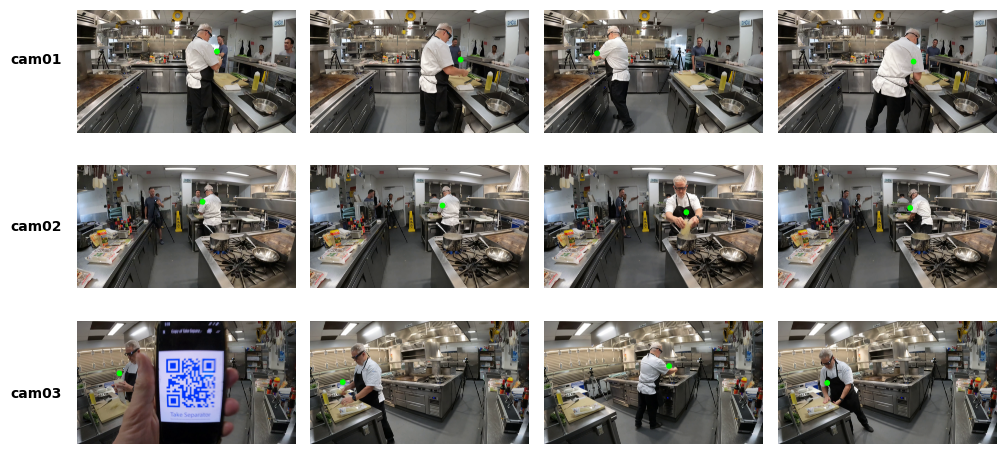

In [20]:
fig, axes = plt.subplots(len(frames_with_points),4, figsize=(10, 5))
for row in range(len(frames_with_points)):
    key = list(frames_with_points.keys())[row]
    for col in range(4):
        timestamp = list(frames_with_points[key].keys())[col]
        ax = axes[row, col]
        ax.axis('off')
        ax.imshow(frames_with_points[key][timestamp])

for i, name in enumerate(frames_with_points.keys()):
    vertical_position = 1 - (i + 0.5) / len(frames_with_points)  # Calculate the vertical position for the name
    fig.text(0.05, vertical_position, name, va='center', ha='right', fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

## Conclusion

In this notebook, we have reviewed how to load takes, and their corresponding VRS and MPS data including the egocentric and exocentric videos and camera calibrations. We further discussed the reprojection of eye gazes from MPS data to egocentric and exocentric views. In this notebook, we use general eye gaze data for eye gaze reprojection. Note that for some takes, personalized eye gaze based on calibrated data is available, which could provide more accurate eye gaze reprojection.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/facebookresearch/Ego4d)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/facebookresearch/Ego4d/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---